# Imports

In [1]:
conda install git

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install git+https://github.com/MaxHalford/prince.git

  Cloning https://github.com/MaxHalford/prince.git to c:\users\gal.hagag\appdata\local\temp\pip-req-build-u76d9k2_
  Resolved https://github.com/MaxHalford/prince.git to commit bd5b29fafe853579c9d41e954caa4504d585665d
Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q https://github.com/MaxHalford/prince.git 'C:\Users\gal.hagag\AppData\Local\Temp\pip-req-build-u76d9k2_'


In [3]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm

import datetime
import prince
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import MDS, SpectralEmbedding, Isomap, LocallyLinearEmbedding, TSNE
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import ttest_ind_from_stats
import gc

import warnings
warnings.filterwarnings("ignore")



In [4]:
%matplotlib inline

# Load Data

In [5]:
# Set seed for reproducibility
np.random.seed(42)  

In [6]:
# data = pd.read_csv('/content/drive/MyDrive/Unsupervised/USCensus1990.data.txt').set_index('caseid')
data = pd.read_csv('USCensus1990.data.txt').set_index('caseid')
print(data.shape)

(2458285, 68)


In [7]:
data.head()

,dAge,dAncstry1,dAncstry2,iAvail,iCitizen,iClass,dDepart,iDisabl1,iDisabl2,iEnglish,...,iTmpabsnt,dTravtime,iVietnam,dWeek89,iWork89,iWorklwk,iWWII,iYearsch,iYearwrk,dYrsserv
caseid,,,,,,,,,,,,,,,,,,,,,
10000,5,0,1,0,0,5,3,2,2,1,...,0,5,0,2,1,1,0,11,1,0
10001,6,1,1,0,0,7,5,2,2,0,...,0,1,0,2,1,1,0,5,1,0
10002,3,1,2,0,0,7,4,2,2,0,...,0,2,0,2,1,1,0,10,1,0
10003,4,1,2,0,0,1,3,2,2,0,...,0,1,0,1,1,1,0,10,1,0
10004,7,1,1,0,0,0,0,2,2,0,...,3,0,0,0,2,2,0,5,6,0


# Sampling Data

we'll sample 10K samples out of 2M rows. Then we'll verify that the samples are representitive of the entire data using statistical tests.

In [8]:
np.random.seed(41)

# sampling 10k rows for the analysis
sample_idx = np.random.choice(data.index, size=10000, replace=False)
sample_data = data.loc[sample_idx]

# sample 30 validation sets of 10k rows for statistical testing
val_mean = []
val_std = []
for i in range(30):
    np.random.seed(i+60)
    val_idx = np.random.choice(data.index, size=10000, replace=False)
    val_mean.append(data.loc[val_idx].mean())
    val_std.append(data.loc[val_idx].std())



In [9]:
samples_ttest = pd.concat(val_mean,axis=1).mean(axis=1).to_frame().rename(columns={0:'val_mean'}) # mean of the all set
samples_ttest['sample_mean'] = data.loc[val_idx].mean()
samples_ttest['val_std'] = pd.concat(val_std,axis=1).mean(axis=1)  # std of the all set

samples_ttest['sample_std'] = data.loc[val_idx].std()

In [10]:
summary = []
for row in range(samples_ttest.shape[0]):
    att = samples_ttest.iloc[row].name
    t_test = ttest_ind_from_stats(mean1=samples_ttest.iloc[row]['sample_mean'], 
                       std1=samples_ttest.iloc[row]['sample_std'], 
                       nobs1=10000, 
                       mean2=samples_ttest.iloc[row]['val_mean'], 
                       std2=samples_ttest.iloc[row]['val_std'], 
                       nobs2=10000*30)
    summary.append([att, t_test.pvalue])
ttest_summary = pd.DataFrame(summary, columns=['variable', 'pvalue'])

In [11]:
ttest_summary.sort_values('pvalue').head()

,variable,pvalue
15,iImmigr,0.054054
48,dRpincome,0.074443
23,dIncome8,0.085882
28,iMarital,0.091164
49,iRPOB,0.096324


**Meaning:** the data sample we chose represent the population: p-value>0.05

In [12]:
# clear cache
del data
data = sample_data.copy()
del sample_data
gc.collect()

4

In [13]:
data.describe()

,dAge,dAncstry1,dAncstry2,iAvail,iCitizen,iClass,dDepart,iDisabl1,iDisabl2,iEnglish,...,iTmpabsnt,dTravtime,iVietnam,dWeek89,iWork89,iWorklwk,iWWII,iYearsch,iYearwrk,dYrsserv
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.843200,3.278100,1.599500,0.114100,0.294700,1.236400,1.377300,1.422900,1.455300,0.21030,...,0.777000,1.486700,0.035500,0.837100,0.99480,1.082800,0.039400,8.412400,1.816300,0.145700
std,2.051886,4.034624,1.753171,0.653394,0.977521,1.767322,1.743746,0.848132,0.850455,0.65201,...,1.300554,1.966777,0.185049,0.866394,0.68558,0.743908,0.194554,4.061475,2.116602,0.420582
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,5.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.000000,0.00000,...,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000,0.000000,10.000000,1.000000,0.000000
75%,6.000000,3.000000,2.000000,0.000000,0.000000,1.000000,3.000000,2.000000,2.000000,0.00000,...,3.000000,3.000000,0.000000,2.000000,1.00000,2.000000,0.000000,11.000000,2.000000,0.000000
max,7.000000,11.000000,12.000000,4.000000,4.000000,9.000000,5.000000,2.000000,2.000000,4.00000,...,3.000000,6.000000,1.000000,2.000000,2.00000,2.000000,1.000000,17.000000,7.000000,2.000000


In [14]:
data.shape

(10000, 68)

# (1)
**Remove the columns dAge, dHispanic, iYearwrk and iSex from the data, and treat those as external variables.**

In [15]:
external = data[['dAge','dHispanic','iYearwrk','iSex']]
data.drop(columns=['dAge','dHispanic','iYearwrk','iSex'], axis=1, inplace=True)

# (2)
**Cluster the remaining columns, and explain what are is the best clustering method.**

### Converting to Numeric Data With MCA

As the description of the dataset mentioned, all attributes are categorical. We'll follow the next steps before clustering:

1. convert all attributes from numerical to categorical.
2. Apply MCA (multiple correspondence analysis) - MCA is a data analysis technique for nominal categorical data, used to detect and represent underlying structures in a data set. It does this by representing data as points in a low-dimensional Euclidean space. Once all the data is in Euclidean space we could perform mathematical calculations on it, distance\similarity calculation for example.(http://vxy10.github.io/2016/06/10/intro-MCA/ , https://www.wikiwand.com/en/Multiple_correspondence_analysis, https://en.wikipedia.org/wiki/Multiple_correspondence_analysis)
3. Dimension reduction to 10 components.
4. Normalize the data - https://developers.google.com/machine-learning/clustering/prepare-datahttps://developers.google.com/machine-learning/clustering/prepare-data


In [16]:
mca = prince.MCA(n_components=10, random_state=42)
mca.fit(data)

original_idx = data.index # keep the original index for matching external variables
data = mca.transform(data)
data.index = original_idx

In [17]:
data.head()

,0,1,2,3,4,5,6,7,8,9
caseid,,,,,,,,,,
102265,0.892702,-0.260268,-0.036947,-0.045308,0.026275,-0.029445,-0.079290,0.115333,-0.341334,0.029201
2362036,0.978412,-0.367777,-0.079289,0.010460,-0.039940,0.013742,0.050160,-0.033989,0.139848,0.005847
48606,-0.433330,-0.326192,0.018658,-0.074334,0.008208,-0.032197,0.187837,-0.291607,-0.223267,-0.123481
1339827,0.024092,0.718965,-0.616343,0.200937,-0.098237,0.248796,-0.303768,-0.113953,0.047963,-0.077738
1645783,-0.570089,-0.118261,0.934595,0.531246,-0.189313,-0.161763,0.000294,-0.151719,0.013676,-0.220182


Normalization is used to eliminate redundant data and ensures that good quality clusters are generated which can improve the efficiency of clustering algorithms.So it becomes an essential step before clustering as Euclidean distance is very sensitive to the changes in the differences

In [18]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data),
                    columns=data.columns,
                    index=data.index)

### Finding the best algorithm for clustering using mean Silhouette score:

https://www.analyticsvidhya.com/blog/2020/10/quick-guide-to-evaluation-metrics-for-supervised-and-unsupervised-machine-learning/https://www.analyticsvidhya.com/blog/2020/10/quick-guide-to-evaluation-metrics-for-supervised-and-unsupervised-machine-learning/

https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891

In [19]:
%%time

silhouette_scores = []

for n in range(2,21):
    # Gaussian Mixtur Model
    gm = GaussianMixture(n_components=n, random_state=42)
    gm_preds = gm.fit_predict(data)
    gm_silhouette_score = silhouette_score(data, gm_preds)

    # KMeans Clustering
    kmean = KMeans(n_clusters=n, random_state=42)
    kmeans_preds = kmean.fit_predict(data)
    kmeans_silhouette_score = silhouette_score(data, kmeans_preds)

    # Agglomerative Clustering
    agg = AgglomerativeClustering(n_clusters=n)
    agg_preds = agg.fit_predict(data)
    agg_silhouette_score = silhouette_score(data, agg_preds)

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=n, random_state=42, eigen_solver="arpack",
                                  affinity="nearest_neighbors")
    spectral_preds = spectral.fit(data).labels_
    spectral_silhouette_score = silhouette_score(data, spectral_preds)

#     print('alive', n)
    silhouette_scores.append([n,
                              gm_silhouette_score,
                              kmeans_silhouette_score,
                              agg_silhouette_score,
                              spectral_silhouette_score])
    
silhouette_df = pd.DataFrame(silhouette_scores,
                             columns=['clusters','GMM', 'KMeans','Agglomerative','Spectral'])
silhouette_df.set_index('clusters', inplace=True)

Wall time: 5min


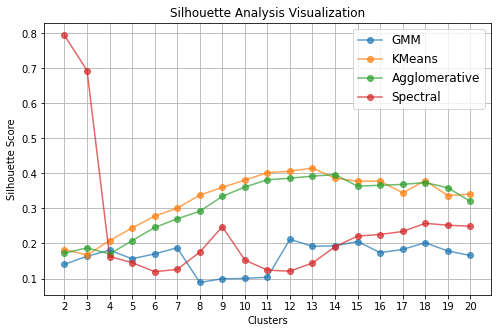

In [20]:
g = silhouette_df.plot(kind='line', marker='o', grid=True, alpha=0.7, 
                       use_index= True,
                       xlabel='Clusters',
                       ylabel='Silhouette Score', #align="center",
                       title='Silhouette Analysis Visualization',
                       figsize=(8,5))
g.legend(loc='best', fontsize=12)
g.set_xticks(silhouette_df.index.astype(int).values)
g.set_xticklabels(silhouette_df.index.astype(int).tolist())
g.set_xlabel('Clusters')
g.set_ylabel('Silhouette Score')

plt.show()

From 4 clusters and above, KMeans and Agglomerative methods achieves the best results (later we'll validate it using statistical tests). We'll try to assess the optimal clusters using 2 methods:

1. Elbow method
2. Silhouette Method 

### Elbow Method

In [21]:
def find_total_clusters(dataset, min, max):
    scores = []
    for n in range(min,max):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(dataset)
        ssd_score = kmeans.inertia_
        scores.append([n, ssd_score])

    scores_df = pd.DataFrame(scores, columns=['Clusters', 'Sum of Squared Distances']).set_index('Clusters')
    g = scores_df.plot(marker='o', figsize=(8,5),
                   use_index= True, grid=True, legend=False)
    g.set_xticks(scores_df.index.astype(int).values)
    g.set_xticklabels(scores_df.index.astype(int).tolist(), fontdict={'fontsize':12})
    g.set_ylabel('Sum of Squared Distances', fontdict={'fontsize':12})
    g.set_xlabel('Clusters', fontdict={'fontsize':12})
    g.set_yticklabels([int(i) for i in g.get_yticks()], fontsize=12)
    g.set_title('Elbow Method for Choosing Clusters', fontsize=14)
#     g.get_figure().savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} Elbow Method for Choosing Clusters.svg', format='svg')

    plt.show()



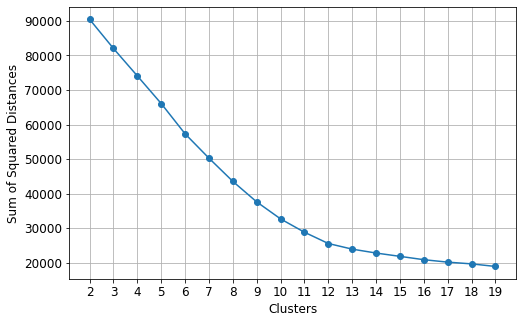

In [24]:
find_total_clusters(data, 2, 20)

Based on this method it's better to have 7-9 clusters

### Dunn's index

DI has a peculiar problem, in that if one of the clusters is badly behaved, where the others are tightly packed, since the denominator contains a 'max' term instead of an average term, the Dunn Index for that set of clusters will be uncharacteristically low. This is thus a worst case indicator

### Silhouette Method

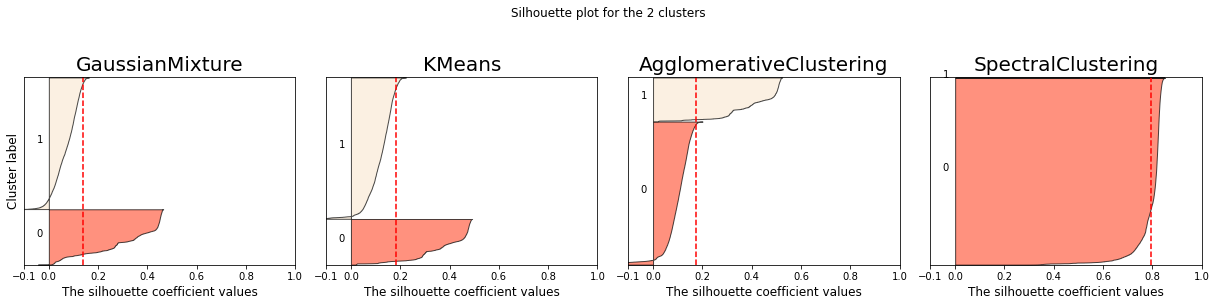

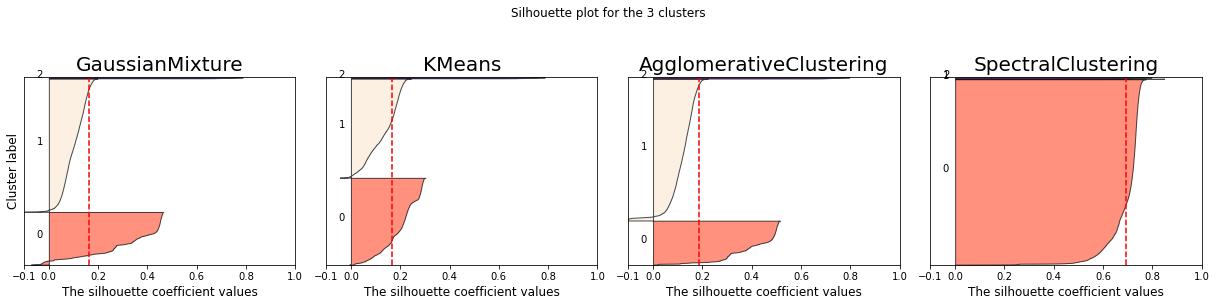

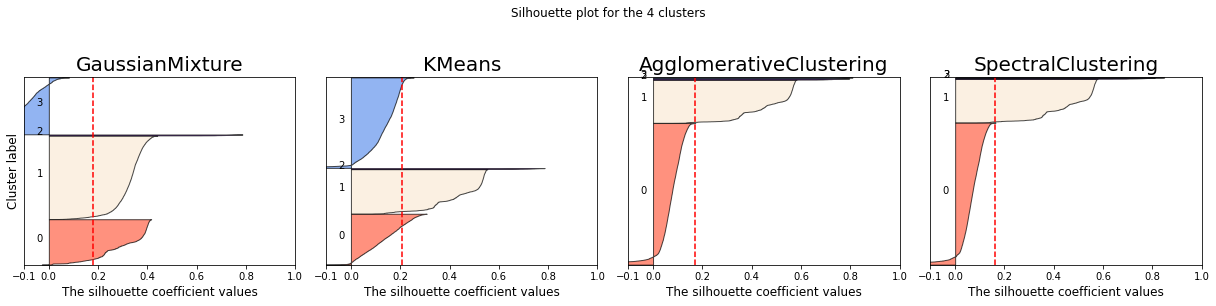

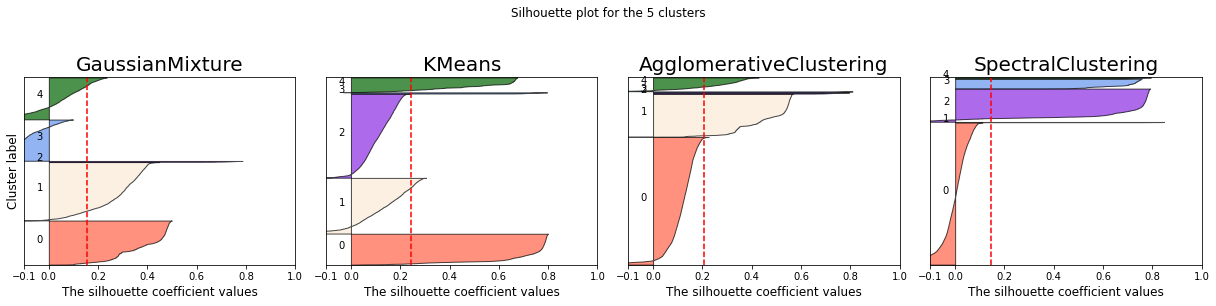

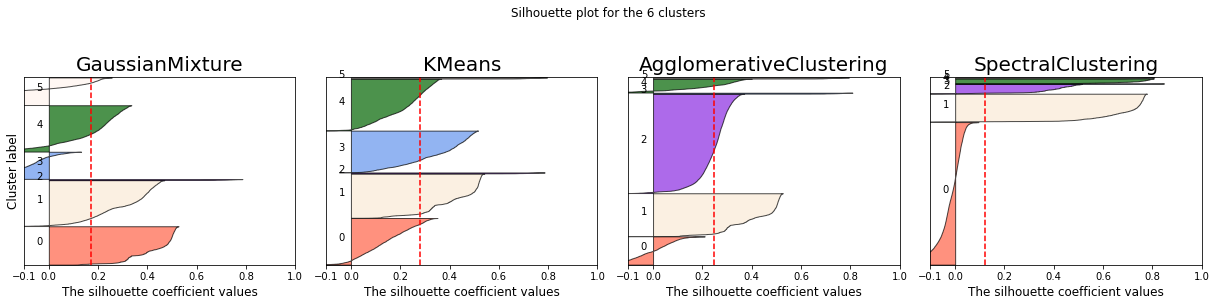

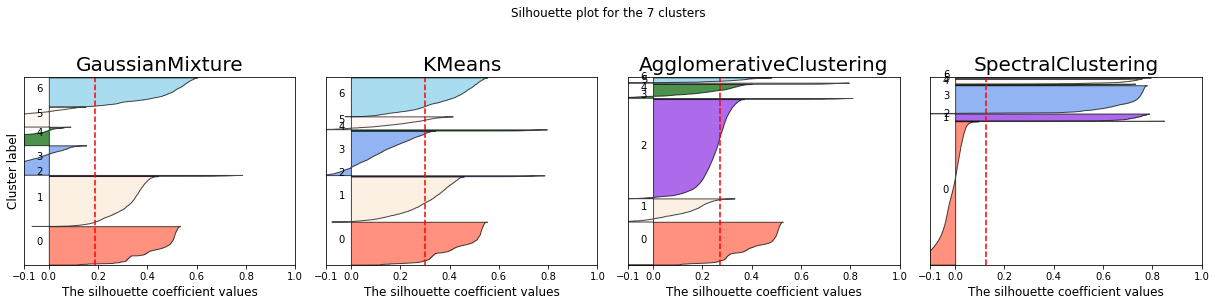

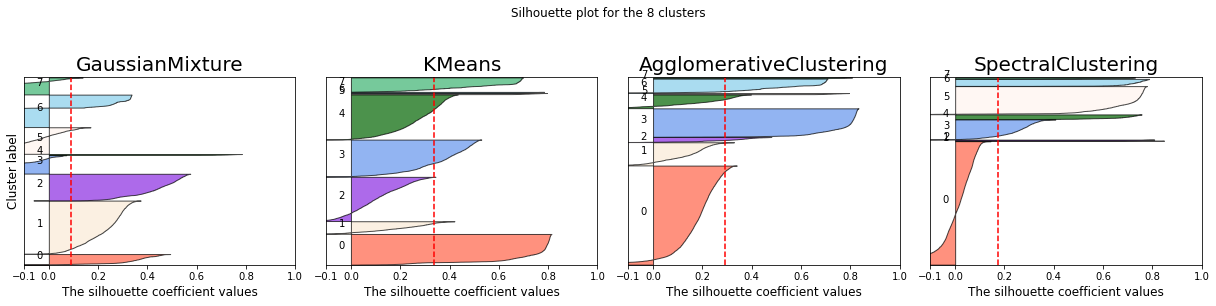

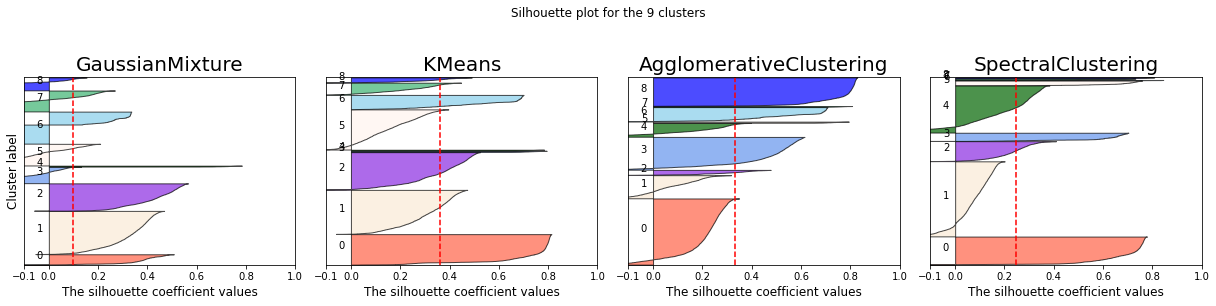

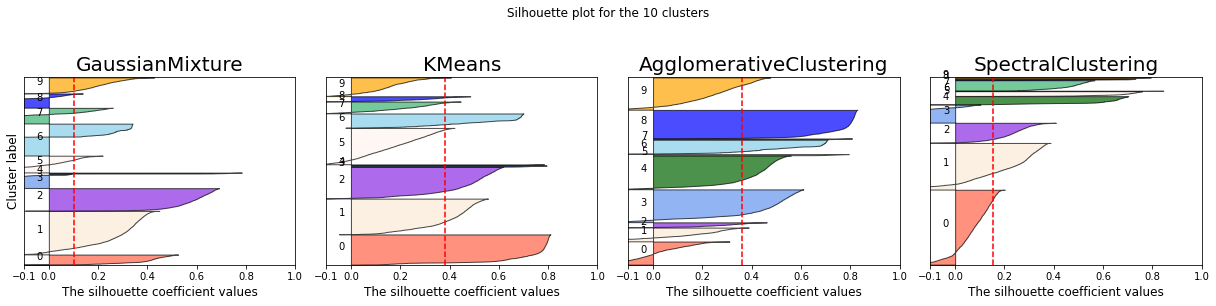

In [25]:
clustering_algo = [gm, kmean, agg, spectral]
colorlist = ["tomato", "antiquewhite", "blueviolet", "cornflowerblue", "darkgreen", "seashell", "skyblue",
                 "mediumseagreen", "blue", "orange", 'cyan', 'magenta']

for n_clusters in range(2,11):
    fig, ax = plt.subplots(1, len(clustering_algo))
    fig.set_size_inches(17, 4)
    
    fig.suptitle(f"Silhouette plot for the {n_clusters} clusters", y=1.05)
    
    for i in range(len(clustering_algo)):
        ax[i].set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax[i].set_ylim([0, len(data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        clusterer = clustering_algo[i]
        algo_name = str(clusterer).split('(')[0]

        if algo_name == 'GaussianMixture':
            clusterer.set_params(**{'n_components': n_clusters})
        else:
            clusterer.set_params(**{'n_clusters': n_clusters})

        cluster_labels = clusterer.fit_predict(data)

        silhouette_avg = silhouette_score(data, cluster_labels)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels) 

        y_lower = 10
        for j in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax[i].fill_betweenx(
              np.arange(y_lower, y_upper),
              0,
              ith_cluster_silhouette_values,
              facecolor=colorlist[j],
              edgecolor='k',
              alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax[i].text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax[i].set_title(algo_name, fontsize=14)
        ax[i].set_xlabel("The silhouette coefficient values", fontsize=12)
        if i==0:
            ax[i].set_ylabel("Cluster label", fontsize=12)
        # The vertical line for average silhouette score of all the values
        ax[i].axvline(x=silhouette_avg, color="red", linestyle="--")

        ax[i].set_yticks([])  # Clear the yaxis labels / ticks
        ax[i].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    fig.tight_layout()
    plt.show()
#     fig.savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} Silhouette plot for the {n_clusters} clusters.svg', format='svg')
# plt.show()

Based on this method we're looking for all cluster with above-average silhouette scores and similar size (thickness) as possible. 7 clusters might just be the most appropriate number of clusters using Spectral clustering. 

# (3)
**Associate the clusters with the external variable, and explain what external variable is best associated with clusters, and what clustering method best associates with the outside variables.**

In [26]:
for col in external.columns:
    print(f"""column {col}: \ntotal unique values: {external[col].nunique()}""")
    print(external[col].value_counts())
    print('===================================\n')

column dAge: 
total unique values: 8
1    1809
4    1641
3    1501
7    1325
5    1309
6    1296
2     980
0     139
Name: dAge, dtype: int64

column dHispanic: 
total unique values: 9
0    9653
2     101
3      54
4      49
9      49
6      45
1      22
8      17
7      10
Name: dHispanic, dtype: int64

column iYearwrk: 
total unique values: 8
1    4875
0    2376
6     861
2     560
7     481
5     412
4     270
3     165
Name: iYearwrk, dtype: int64

column iSex: 
total unique values: 2
1    5074
0    4926
Name: iSex, dtype: int64



### Scoring

Based on each external variable (assuming they represent the true label), we'll cluster the data (number of clusters will match the label's unique values) and assess the score of each method.

**Homogeneity** metric of a cluster labeling given ground truth. A clustering result satisfies homogeneity if all of its clusters contain only data points that are members of a single class. This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way. The score range is 0 (no homogeneity) and 1 (perfect homogeneity).

**Completeness** metric of a cluster labeling is given ground truth. A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster. This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way. The score range is (0,1).

**V-measure** is the harmonic mean between homogeneity and completeness:

v = (1 + beta) * homogeneity * completeness / (beta * homogeneity + completeness)

This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way. A score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.

**Adjusted Mutural Information** - AMI is an adjustment of the Mutual Information (MI) score to account for chance. It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared. Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the Mutual Information is a function that measures the agreement of the two assignments, ignoring permutations. The score ranges between 0.0 for random match and 1.0 for perfectly complete labeling.

sklearn.metrics.adjusted_mutual_info_score
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

### Hyperparameters Tuning

We use `GridSearchCV` to assess the results (MI Score) of each method with different hyperparameters by "learning" the patterns on train set and validate the score on validation set (cross validates of 5 sets). The best hyperparameters of each method will be compared afterwards in order to find the best one.

In [27]:
def gmm_tuning(n_clusters, dataset, label):
    gm_params = {
        'covariance_type':['full', 'tied', 'diag', 'spherical'],
        'reg_covar': [1e-6,1e-5,1e-4,1e-3,1e-2],
        'tol':[1e-4,1e-3,1e-2]
    }

    gm = GaussianMixture(n_components=n_clusters, random_state=42)
    rs = GridSearchCV(estimator=gm ,param_grid=gm_params ,n_jobs=-1, cv=5, scoring='adjusted_mutual_info_score')

    rs.fit(dataset, external.loc[dataset.index, label])

#     apply best hyperparameters found   
    return gm.set_params(**rs.best_params_)


def kmeans_tuning(n_clusters, dataset, label):

    kmeans_params = {
        'init' : ['k-means++', 'random'],
        'algorithm': ['full', 'elkan'],
        'tol':[1e-4,1e-3,1e-2]
    }

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    rs = GridSearchCV(estimator=kmeans ,param_grid=kmeans_params ,n_jobs=-1, cv=5, scoring='adjusted_mutual_info_score')
    rs.fit(dataset, external.loc[dataset.index, label])

#     apply best hyperparameters found    
    return kmeans.set_params(**rs.best_params_)


def agglomerative_tuning(n_clusters, dataset, label):
    agg_params = {
        'affinity' : ["euclidean", "l1", "l2"],
        'linkage': ['ward', 'complete', 'average', 'single']
    }

    agg = AgglomerativeClustering(n_clusters=n_clusters)
    rs = GridSearchCV(estimator=agg ,param_grid=agg_params ,n_jobs=-1, cv=5, scoring='adjusted_mutual_info_score')
    rs.fit(dataset, external.loc[dataset.index, label])
    
#     apply best hyperparameters found
    return agg.set_params(**rs.best_params_)


def spectral_tuning(n_clusters, dataset, label):
    spectral_params = {
        'affinity' : ["nearest_neighbors"],
        'n_neighbors': [5, 10, 15, 20]
    }

    spectral = SpectralClustering(random_state=42, n_clusters=n_clusters)
    rs = GridSearchCV(estimator=spectral ,param_grid=spectral_params ,n_jobs=-1, cv=5, scoring='adjusted_mutual_info_score', verbose=0)
    rs.fit(dataset, external.loc[dataset.index, label])

#     apply best hyperparameters found    
    return spectral.set_params(**rs.best_params_)

### Comparing Methods Scores

In [28]:
def score_cluster_with_labels(dataset, label_name, tuned_models=None):

    n_clusters = external[label_name].nunique() # n_cluster is similar to the labels unique values
    scores_ls = []

    idx = dataset.index

#     load or turn models
    if tuned_models:
        gm, kmean, agg, spectral = tuned_models[label]
    else:
        gm = gmm_tuning(n_clusters=n_clusters, dataset=dataset, label=label_name)
        kmean = kmeans_tuning(n_clusters=n_clusters, dataset=dataset, label=label_name)
        agg = agglomerative_tuning(n_clusters=n_clusters, dataset=dataset, label=label_name)
        spectral = spectral_tuning(n_clusters=n_clusters, dataset=dataset, label=label_name)
    
    # Gaussian Mixture Model
    gm_preds = gm.fit_predict(dataset)
    gm_v_score = v_measure_score(external.loc[idx, label_name], gm_preds)
    gm_mi_score = adjusted_mutual_info_score(external.loc[idx, label_name], gm_preds)

    # KMeans Clustering
    kmeans_preds = kmean.fit_predict(dataset)
    kmean_v_score = v_measure_score(external.loc[idx, label_name], kmeans_preds)
    kmean_mi_score = adjusted_mutual_info_score(external.loc[idx, label_name], kmeans_preds)

    # Agglomerative Clustering
    agg_preds = agg.fit_predict(dataset)
    agg_v_score = v_measure_score(external.loc[idx, label_name], agg_preds)
    agg_mi_score = adjusted_mutual_info_score(external.loc[idx, label_name], agg_preds)

    # Spectral Clustering
    spectral_preds = spectral.fit(dataset).labels_
    spectral_v_score = v_measure_score(external.loc[idx, label_name], spectral_preds)
    spectral_mi_score = adjusted_mutual_info_score(external.loc[idx, label_name], spectral_preds)

    scores_ls.append([gm_v_score,
                      kmean_v_score,
                      agg_v_score,
                      spectral_v_score,
                      gm_mi_score,
                      kmean_mi_score,
                      agg_mi_score,
                      spectral_mi_score])

    scores_pd = pd.DataFrame(scores_ls, columns=['gm_v_score',
                                                'kmean_v_score',
                                                'agg_v_score',
                                                'spectral_v_score',
                                                 'gm_mi_score',
                                                'kmean_mi_score',
                                                'agg_mi_score',
                                                'spectral_mi_score']).T
    

    return scores_pd, [gm, kmean, agg, spectral]

In [29]:
%%time
score_labels = pd.DataFrame()
tuned_models = {}
i=1
for label in external.columns:
    # get scores for each label
    score_labels[label], tuned_models[label]  = score_cluster_with_labels(data, label)
#     print(f'alive: {i} out of {len(external.columns)}')
    i+=1
score_labels

Wall time: 6min 54s


,dAge,dHispanic,iYearwrk,iSex
gm_v_score,0.361052,0.051227,0.589276,0.039217
kmean_v_score,0.348024,0.054483,0.541782,0.001086
agg_v_score,0.311747,0.051420,0.375451,0.000475
spectral_v_score,0.331321,0.010232,0.386836,0.000150
gm_mi_score,0.360193,0.048272,0.588634,0.039144
kmean_mi_score,0.347149,0.051563,0.541068,0.001006
agg_mi_score,0.310739,0.048401,0.374372,0.000394
spectral_mi_score,0.330235,0.006909,0.385684,0.000005


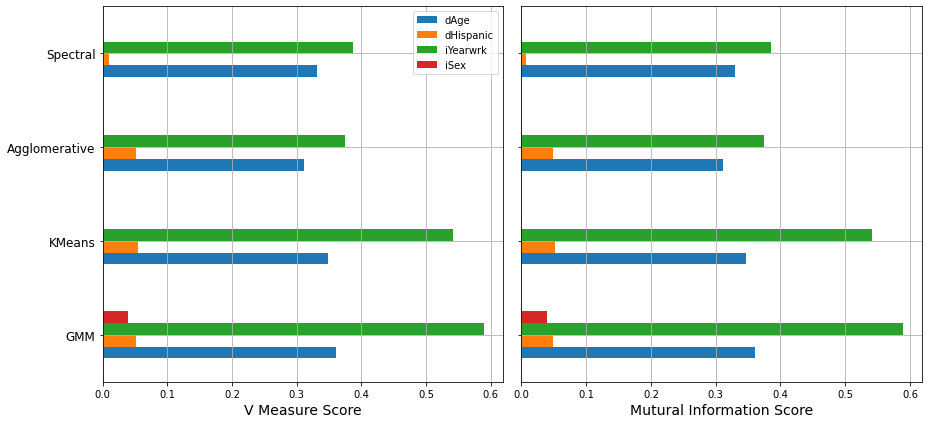

In [30]:
mi_cols = ['gm_mi_score', 'kmean_mi_score', 'agg_mi_score', 'spectral_mi_score']
v_cols = ['gm_v_score','kmean_v_score','agg_v_score','spectral_v_score']

fig, ax = plt.subplots(1,2, figsize=(13,6))
g = score_labels.loc[v_cols].plot(kind='barh', 
                                   grid=True, legend='right_bottom', ax=ax[0])
g.set_yticklabels(['GMM','KMeans','Agglomerative','Spectral'], fontdict={'fontsize':12})
g.set_xlabel('V Measure Score', fontdict={'fontsize':14})
# g.set_xticklabels([str(round(i,3)) for i in g.get_xticks()], fontsize = 18)
# plt.setp(g.get_legend().get_texts(), fontsize='20')

h = score_labels.loc[mi_cols].plot(kind='barh',
                                   grid=True, legend=False, ax=ax[1])
h.set_yticklabels('')
h.set_xlabel('Mutural Information Score', fontdict={'fontsize':14})
# h.set_xticklabels([str(round(i,3)) for i in h.get_xticks()], fontsize = 18)
fig.suptitle('V Measure and MI Score per Labels', fontsize=16, y=1)

fig.tight_layout()
# fig.savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} V Measure and MI Score per Labels.svg', format='svg')

plt.show()

### Tests for finding the best algorithm

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups

stats.f_oneway functions take the groups as input and return ANOVA F and p-value

The Tukey test is a post-hoc exam, meaning it is run after completing the ANOVA to determine which groups specifically differ. It is necessary to run when rejecting the null hypothesis in an ANOVA test with more than 2 groups, because the ANOVA does not identify the differences between all the combinations of groups. The Tuki test does just this.

In [31]:
%%time
# performing 30 samples, calculating v_measure score and then performing ANOVA test
anova_v_measure = []
anova_mi_measure = []

data_size = len(data)
sample_size = data_size // 5

for label in external.columns:
    for i in range(30):
        idx_4_test = np.random.choice(data.index.to_numpy(), size=sample_size, replace=False)
        anova_df = score_cluster_with_labels(dataset=data.loc[idx_4_test], label_name=label, 
                                            tuned_models=tuned_models)[0]
        anova_df.columns = [f'{label}_{i+1}']
        anova_v_measure.append(anova_df.loc[v_cols])
        anova_mi_measure.append(anova_df.loc[mi_cols])    

full_v_score = pd.concat(anova_v_measure, axis=1)
full_mi_score = pd.concat(anova_mi_measure, axis=1)


Wall time: 1min 57s


In [32]:
# spliting into seperate df for each label
dAge_v_scores = full_v_score.loc[:,full_v_score.columns.str.contains('dAge')].T
dHispanic_v_scores = full_v_score.loc[:,full_v_score.columns.str.contains('dHispanic')].T
iYearwrk_v_scores = full_v_score.loc[:,full_v_score.columns.str.contains('iYearwrk')].T
iSex_v_scores = full_v_score.loc[:,full_v_score.columns.str.contains('iSex')].T

In [33]:
# spliting into seperate df for each label
dAge_mi_scores = full_mi_score.loc[:,full_mi_score.columns.str.contains('dAge')].T
dHispanic_mi_scores = full_mi_score.loc[:,full_mi_score.columns.str.contains('dHispanic')].T
iYearwrk_mi_scores = full_mi_score.loc[:,full_mi_score.columns.str.contains('iYearwrk')].T
iSex_mi_scores = full_mi_score.loc[:,full_mi_score.columns.str.contains('iSex')].T

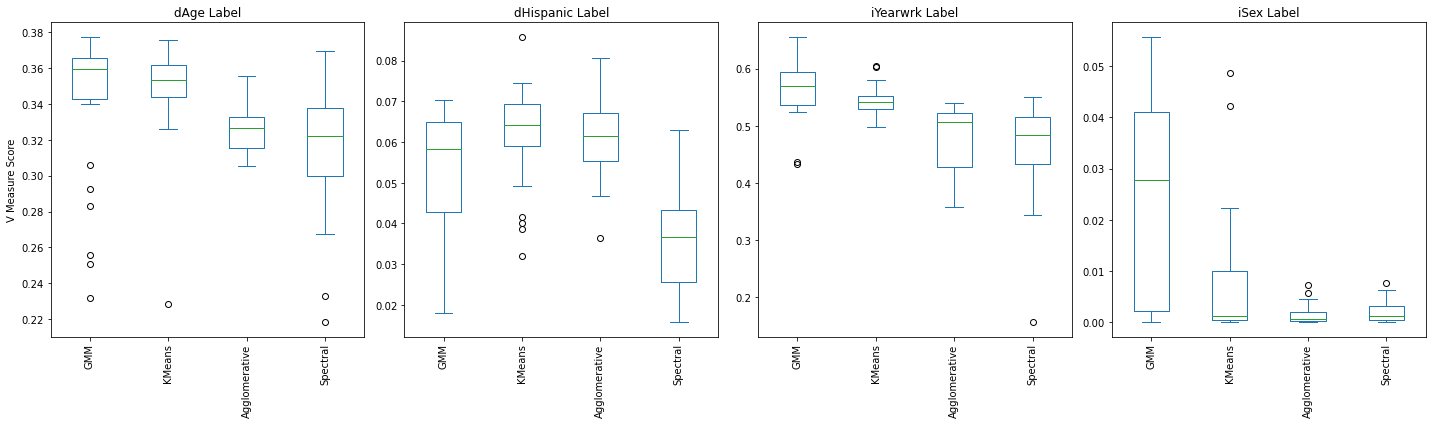

In [34]:
# visualizing the difference - V measure

fig, ax = plt.subplots(1,4, figsize=(20,6))

g = dAge_v_scores.plot(kind='box', title='dAge Label', ax=ax[0], sharey=False, rot=90)
g.set_ylabel('V Measure Score')
g.set_xticklabels(['GMM','KMeans','Agglomerative','Spectral'])

h = dHispanic_v_scores.plot(kind='box', title='dHispanic Label', ax=ax[1], sharey=False, rot=90)
h.set_xticklabels(['GMM','KMeans','Agglomerative','Spectral'])

j = iYearwrk_v_scores.plot(kind='box', title='iYearwrk Label', ax=ax[2], sharey=False, rot=90)
j.set_xticklabels(['GMM','KMeans','Agglomerative','Spectral'])

k = iSex_v_scores.plot(kind='box', title='iSex Label', ax=ax[3], sharey=False, rot=90)
k.set_xticklabels(['GMM','KMeans','Agglomerative','Spectral'])

g.set_title('V Measure Score Range with Respect to External Vars.svg', fontsize=14)

fig.tight_layout()

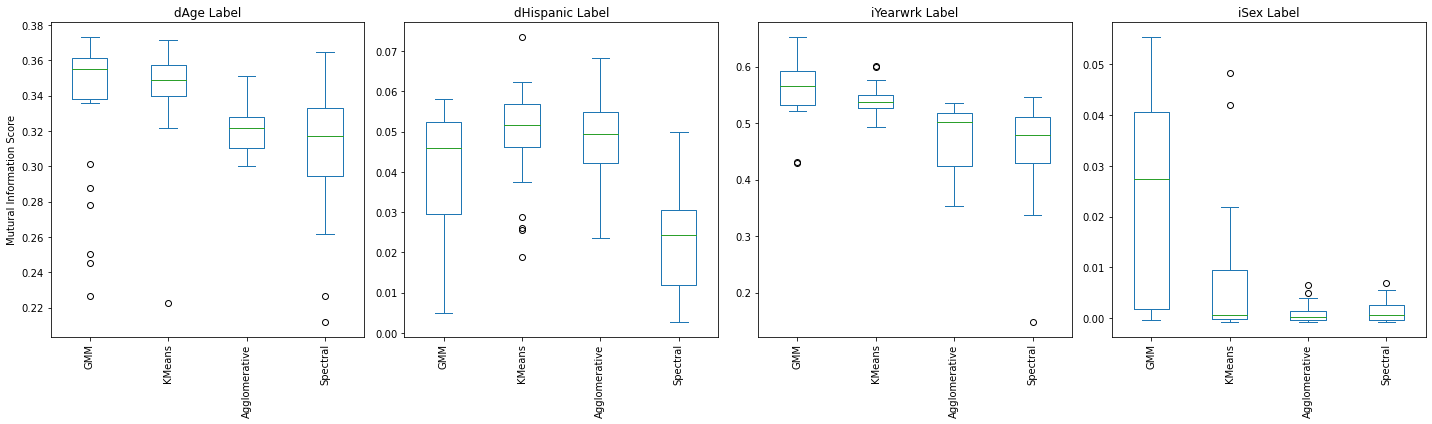

In [35]:
# visualizing the difference - MI Score

fig, ax = plt.subplots(1,4, figsize=(20,6))

g = dAge_mi_scores.plot(kind='box', title='dAge Label', ax=ax[0], sharey=False, rot=90)
g.set_ylabel('Mutural Information Score')
g.set_xticklabels(['GMM','KMeans','Agglomerative','Spectral'])

h = dHispanic_mi_scores.plot(kind='box', title='dHispanic Label', ax=ax[1], sharey=False, rot=90)
h.set_xticklabels(['GMM','KMeans','Agglomerative','Spectral'])

j = iYearwrk_mi_scores.plot(kind='box', title='iYearwrk Label', ax=ax[2], sharey=False, rot=90)
j.set_xticklabels(['GMM','KMeans','Agglomerative','Spectral'])

k = iSex_mi_scores.plot(kind='box', title='iSex Label', ax=ax[3], sharey=False, rot=90)
k.set_xticklabels(['GMM','KMeans','Agglomerative','Spectral'])

g.set_title('MI Score Range with Respect to External Vars.svg', fontsize=14)
fig.tight_layout()
# fig.savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} MI Score Range with Respect to External Vars.svg', format='svg')
plt.show()

**iYearwrk is the external variable which is best associated with clusters.** 

The results are in different scale so no statistical test is required to verify it (there's no overlap). We will perform ANOVA test to verify which clustering method is superior.

In [36]:
iSex_v_scores.head()

,gm_v_score,kmean_v_score,agg_v_score,spectral_v_score
iSex_1,0.041794,0.000789,0.000299,0.000967
iSex_2,0.044044,0.004627,0.004627,0.004627
iSex_3,0.040908,0.000771,0.000073,0.000311
iSex_4,0.003559,0.004206,0.004206,0.001054
iSex_5,0.019956,0.019441,0.000216,0.003253


In [37]:
def tukeyhsd(dataset):
    dataset = dataset.T
    dataset['combined'] = dataset.values.tolist()
    dataset = (dataset[['combined']].reset_index().explode('combined')
                  .rename(columns={'index':'method','combined':'v_measure_score'})
                  .reset_index(drop=True))

    dataset.v_measure_score = dataset.v_measure_score.astype(float)

    print(pairwise_tukeyhsd(dataset['v_measure_score'], dataset['method']))

In [38]:
labels_dict = {
    'dAge': dAge_v_scores,
    'dHispanic': dHispanic_v_scores,
    'iYearwrk': iYearwrk_v_scores,
    'iSex': iSex_v_scores
}

# perform ANOVA test & Tukey 

for label in labels_dict.keys():
    print(f'ANOVA results for label {label}:')
    F, p = stats.f_oneway(labels_dict[label]['gm_v_score'], 
                        labels_dict[label]['kmean_v_score'], 
                        labels_dict[label]['agg_v_score'], 
                        labels_dict[label]['spectral_v_score'])
    print(f'F-Statistic={F:.3f}, p={p:.3f}\n')

    tukeyhsd(labels_dict[label])
    print('\n')

ANOVA results for label dAge:
F-Statistic=7.179, p=0.000

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2      meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
  agg_v_score       gm_v_score   0.0155 0.2101 -0.0051  0.0361  False
  agg_v_score    kmean_v_score   0.0229 0.0233  0.0023  0.0434   True
  agg_v_score spectral_v_score  -0.0103  0.554 -0.0309  0.0103  False
   gm_v_score    kmean_v_score   0.0074 0.7609 -0.0132   0.028  False
   gm_v_score spectral_v_score  -0.0258 0.0078 -0.0464 -0.0052   True
kmean_v_score spectral_v_score  -0.0332  0.001 -0.0538 -0.0126   True
---------------------------------------------------------------------


ANOVA results for label dHispanic:
F-Statistic=28.006, p=0.000

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2      meandiff p-adj   lower   upper  reject
------------------------------------

**For `iYearwrk` variable as clustering label Spectral method achived the best performance (p value = 0.001)**

# (4)
**Find anomalies in the data, and test whether anomalies are associated with any of the external variables.**

### Find Anomalies with DBSCAN (density based)

We'll use DBSCAN method to find anomalies in the dataset. A cluster is defined as a set of core samples close to each other (we use euclidean as distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). As a result, anomalies points can be identified as not belonging to any cluster. There are two parameters to the algorithm, min-samples and eps, which define the density of a cluster. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

First we'll find eps hyperparameter:



In [39]:
def find_parameter_for_dbs(dataset, kwrd=None):
  
    neighbors = NearestNeighbors(n_neighbors=10) 
    neighbors_fit = neighbors.fit(dataset)
    distances, indices = neighbors_fit.kneighbors(dataset)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    fig, ax = plt.subplots(figsize=(8,5))
    plt.title('Finding Optimal eps for DBScan')
    ax.set_xlabel('Data Point', fontdict={'fontsize':14})
    ax.set_ylabel('eps', fontdict={'fontsize':14})
#     ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
#     ax.tick_params(axis = 'both', which = 'minor', labelsize = 18)
    ax.grid(True)
    ax.plot(distances, **kwrd)
#     fig.savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} Finding Optimal eps for DBScan.svg', format='svg')
    
    plt.show()
    
# https://www.kaggle.com/tanmaymane18/nearestneighbors-to-find-optimal-eps-in-dbscan

Lets consider 20 as n_neighbors and plot the distances of each point in ascending order of the distance, elbow point will give us the samller range for optimal eps value.

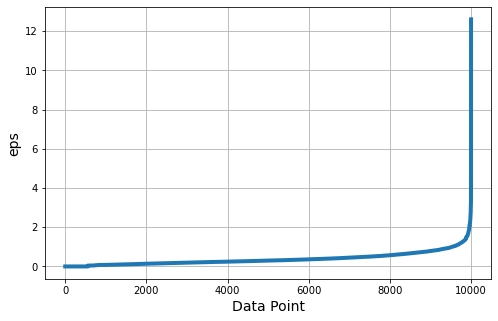

In [40]:
find_parameter_for_dbs(data, {'linewidth':4})

Another method to find eps: two graphs showing the mean silhouette score in
relation to the ”eps” hyperparameter and in relation to the number of clusters. We'll select `eps` according to the `elbow` method as reflected in these graphs


In [41]:
db_silhouette = []
for eps in np.linspace(0.1,2,100):
    dbscan = DBSCAN(eps=eps, min_samples=11)
    db_preds = dbscan.fit_predict(data)
    clusters = len(np.unique(db_preds))
    anomalies_size = len(np.where(db_preds==-1)[0]) / len(db_preds)
    if clusters>1:
        db_silhouette.append([eps, silhouette_score(data, db_preds), clusters, anomalies_size])
    else:
        continue


In [42]:
eps_df = pd.DataFrame(db_silhouette, columns=['eps','silhouette_score', 'clusters', 'anomalies_size']).set_index('eps')
eps_df.sort_values('silhouette_score', ascending=False).head()

,silhouette_score,clusters,anomalies_size
eps,,,
1.865657,0.639114,3,0.0156
1.846465,0.635524,3,0.0159
1.827273,0.630227,3,0.0165
1.808081,0.630103,3,0.0168
1.788889,0.623801,3,0.0174


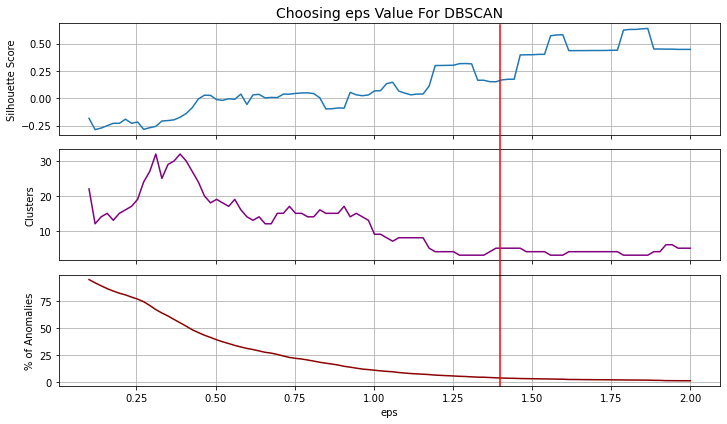

In [45]:
fig, ax = plt.subplots(3,1, figsize=(10,6))
eps_df[['silhouette_score']].plot(kind='line', grid=True, ylabel='Silhouette Score', ax=ax[0], 
                                  sharex=True, legend=False)
eps_df[['clusters']].plot(kind='line', grid=True, ylabel='Clusters', ax=ax[1], color='purple', legend=False)
(eps_df[['anomalies_size']]*100).plot(kind='line', grid=True, ylabel='% of Anomalies', ax=ax[2], color='darkred', legend=False)
# ax[1].set_yticks(np.arange(1,6))
ax[0].set_title('Choosing eps Value For DBSCAN', fontsize=14)
plt.axvline(x=1.4, ymin=0, ymax=3.24, clip_on=False, color='r')

fig.tight_layout()
# fig.savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} Choosing eps Value For DBSCAN.svg', format='svg')
plt.show()

Using the optimal hypermarameters to fit DBScan

In [44]:
eps = 1.4
dbscan = DBSCAN(eps=eps, min_samples=12)
db_preds = pd.DataFrame(dbscan.fit_predict(data), index=data.index, columns=['cluster'])

# anomalies are tagges as -1
anomalies = db_preds.query("cluster==-1")
print('total clusters:', db_preds.cluster.nunique())
print('total outliers:', len(anomalies))

total clusters: 4
total outliers: 375


#### Scores of DBSCAN clustering

In [46]:
non_anomaly_idx = db_preds.query("cluster!=-1").index
db_silhouette_score = silhouette_score(data.loc[non_anomaly_idx], 
                                       db_preds.loc[non_anomaly_idx])
db_mi_score = adjusted_mutual_info_score(db_preds.loc[non_anomaly_idx,'cluster'], external.loc[non_anomaly_idx,'iYearwrk'])
print(f'silhouette_score: {db_silhouette_score:.3f} \nMI Score with iYearwrk variable: {db_mi_score:.3f}')

silhouette_score: 0.401 
MI Score with iYearwrk variable: 0.003


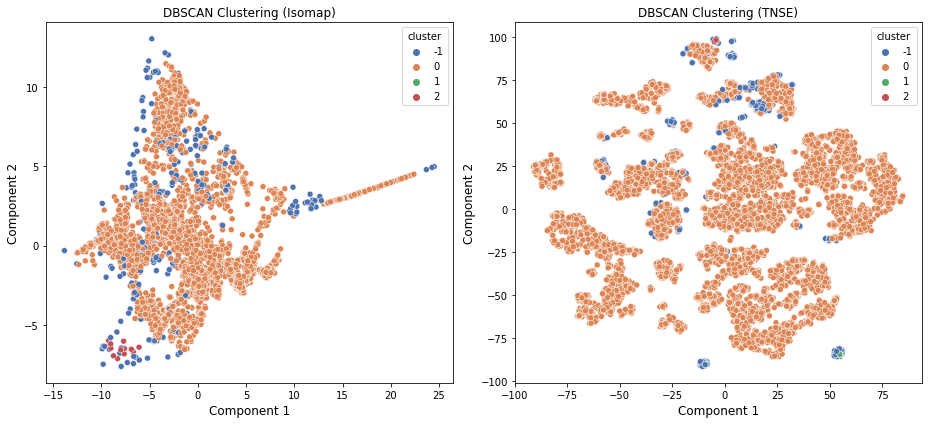

In [47]:
# plotting the anomalies -- first we reduce the demensions into 2 using isomap
iso = Isomap(n_neighbors=5, n_components=2, eigen_solver='arpack')
data_iso = pd.DataFrame(iso.fit_transform(data), index=data.index, columns=['component_1','component_2'])

fig, ax = plt.subplots(1,2, figsize=(13,6))

g = sns.scatterplot(data=data_iso,  x='component_1', y='component_2',hue=db_preds['cluster'], palette="deep",
                ax=ax[0])
g.set_title('DBSCAN Clustering (Isomap)')
g.set_xlabel('Component 1', fontsize=12)
g.set_ylabel('Component 2', fontsize=12)

# plotting the anomalies -- first we reduce the demensions into 2 using TSNE
mds = TSNE(n_components=2, n_jobs=-1, random_state=42)
data_tsne = pd.DataFrame(mds.fit_transform(data), index=data.index, columns=['component_1','component_2'])

h = sns.scatterplot(data=data_tsne,  x='component_1', y='component_2',hue=db_preds['cluster'], palette="deep",
                ax=ax[1])
h.set_title('DBSCAN Clustering (TNSE)')
h.set_xlabel('Component 1', fontsize=12)
h.set_ylabel('Component 2', fontsize=12)

fig.tight_layout()
# fig.savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} Visualization of Anomalies (Density).svg', format='svg')

plt.show()

### Find Anomalies with KNN (distance based)

In [48]:
# instantiate model
nbrs = NearestNeighbors(n_neighbors=5)
# fit model
nbrs.fit(data)

NearestNeighbors()

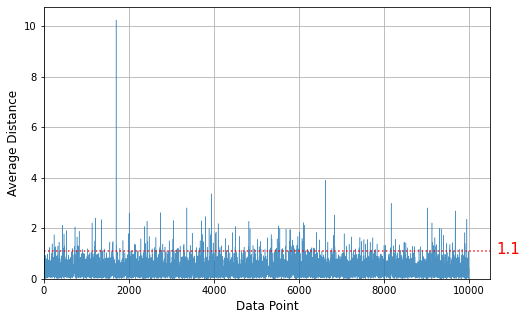

In [49]:
# distances and indexes of k-neaighbors from model outputs
distances, indexes = nbrs.kneighbors(data)
mean_dist = pd.DataFrame(distances.mean(axis=1), columns=['avg_distance'], index=data.index)

# plot mean of k-distances of each observation
fig, ax = plt.subplots(figsize=(8,5))

mean_dist.reset_index(drop=True).plot(kind='line', ax=ax, legend=False, grid=True, alpha=0.8, linewidth=0.5)

threshold = 1.1
ax.axhline(threshold, color='r', alpha=0.9, linestyle=':')
ax.set_ylim(0,)
ax.set_xlim(0,)
ax.set_ylabel('Average Distance', fontdict={'fontsize':12})
ax.set_xlabel('Data Point', fontdict={'fontsize':12})
ax.set_title('Average Distance for Anomalies', fontsize=14)
# ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
# ax.tick_params(axis = 'both', which = 'minor', labelsize = 18)

fig.text(x=0.91, y=0.195, s=threshold, c='r', size=15)
# fig.savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} Average Distance for Anomalies.svg', format='svg')

plt.show()

As we can see, there are some spikes in distance measures, and these spikes are potentially anomalies or outliers in the dataset.

In [50]:
# filter outliers
outlier_values = mean_dist.query("avg_distance>@threshold")
print('total outliers:', len(outlier_values))

total outliers: 269


In [51]:
mean_dist['anomaly'] = mean_dist.avg_distance.apply(lambda x: 'Anomaly' if x>threshold else 'Not Anomaly')

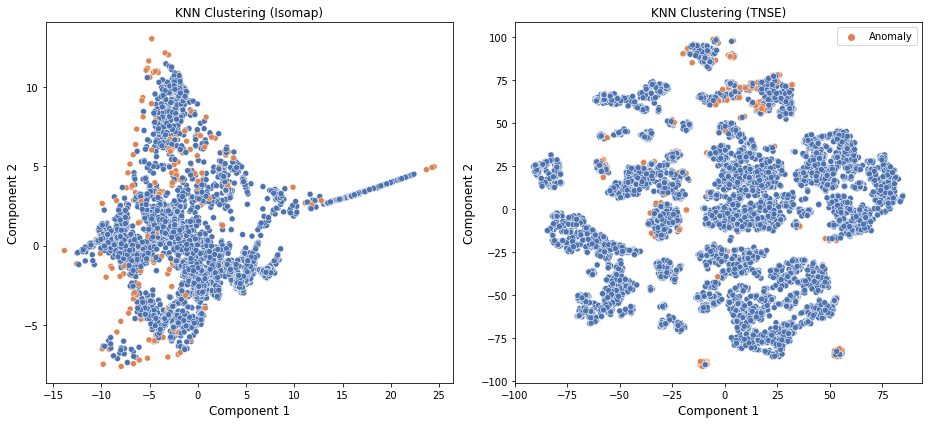

In [52]:
# plotting the anomalies -- isomap

fig, ax = plt.subplots(1,2, figsize=(13,6))

g = sns.scatterplot(data=data_iso,  x='component_1', y='component_2',hue=mean_dist['anomaly'], palette="deep",
                ax=ax[0])
g.set_title('KNN Clustering (Isomap)')
g.set_xlabel('Component 1', fontsize=12)
g.set_ylabel('Component 2', fontsize=12)

# plotting the anomalies -- TSNE

h = sns.scatterplot(data=data_tsne,  x='component_1', y='component_2',hue=mean_dist['anomaly'], palette="deep",
                ax=ax[1])
h.set_title('KNN Clustering (TNSE)')
h.set_xlabel('Component 1', fontsize=12)
h.set_ylabel('Component 2', fontsize=12)

handles, labels = h.get_legend_handles_labels()
h.legend(handles=handles[1:], labels=labels[1:])
handles, labels = g.get_legend_handles_labels()
g.legend().remove()

fig.tight_layout()
# fig.savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} Visualization of Anomalies (Distance).svg', format='svg')

plt.show()

Checking for association between external variables and anomalies:

In [53]:
# DBSCAN anomalies:
score_labels_anomalies = pd.DataFrame()

for label in external.columns:
    # get scores for each label
    score_labels_anomalies[label] = score_cluster_with_labels(anomalies, label, tuned_models=tuned_models)[0]

score_labels_anomalies.loc[mi_cols]

,dAge,dHispanic,iYearwrk,iSex
gm_mi_score,6.914053e-17,-2.543900e-16,7.253593e-17,-1.751282e-15
kmean_mi_score,6.914053e-17,-2.543900e-16,7.253593e-17,-1.751282e-15
agg_mi_score,-1.858943e-03,-1.689028e-02,-2.607291e-03,-1.682199e-03
spectral_mi_score,-3.353714e-04,-1.590965e-03,1.570862e-02,3.979279e-04


In [54]:
# KNN anomalies:
score_labels_anomalies_knn = pd.DataFrame()
anomaly_idx_knn = mean_dist.query("anomaly=='Anomaly'").index

for label in external.columns:
    # get scores for each label
    score_labels_anomalies_knn[label] = score_cluster_with_labels(data.loc[anomaly_idx_knn], label, tuned_models=tuned_models)[0]

score_labels_anomalies_knn.loc[mi_cols]

,dAge,dHispanic,iYearwrk,iSex
gm_mi_score,0.128640,0.189633,0.101381,0.005792
kmean_mi_score,0.100853,0.195188,0.093602,0.005792
agg_mi_score,0.071958,0.190703,0.085665,0.003658
spectral_mi_score,0.079633,0.214156,0.112126,0.009380


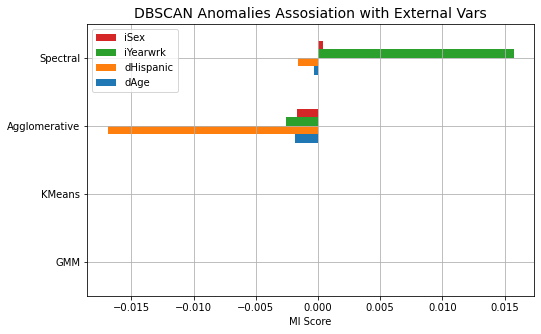

In [56]:
g = score_labels_anomalies.loc[mi_cols].plot(kind='barh',
                                               figsize=(8,5), grid=True, legend='reverse')
g.set_yticklabels(['GMM','KMeans','Agglomerative','Spectral'])
g.set_xlabel('MI Score')
g.set_title('DBSCAN Anomalies Assosiation with External Vars', fontsize=14)
# g.get_figure().savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} DBSCAN Anomalies Assosiation with External Vars.svg',
#                        format='svg')

plt.show()

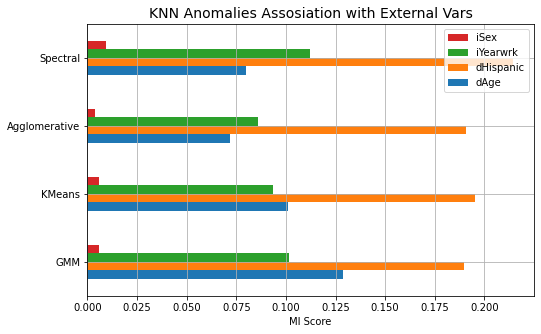

In [57]:
g = score_labels_anomalies_knn.loc[mi_cols].plot(kind='barh',
                                               figsize=(8,5), grid=True, legend='reverse')
g.set_yticklabels(['GMM','KMeans','Agglomerative','Spectral'])
g.set_xlabel('MI Score')
g.set_title('KNN Anomalies Assosiation with External Vars', fontsize=14)
# g.get_figure().savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} KNN Anomalies Assosiation with External Vars.svg',
#                        format='svg')

plt.show()

In [58]:
# t-test to check if there is correlation between the external variables and the anomalies

# DBSCAN
print("DBSCAN Anomalies:")
for var in external.columns:
    F, p = stats.ttest_1samp(score_labels_anomalies.loc[mi_cols][var], 0)
    print(f"label {var}: p-value={p:.4f}")
print()

# KNN
print("KNN Anomalies:")
for var in external.columns:
    F, p = stats.ttest_1samp(score_labels_anomalies_knn.loc[mi_cols][var], 0)
    print(f"label {var}: p-value={p:.4f}")

DBSCAN Anomalies:
label dAge: p-value=0.3045
label dHispanic: p-value=0.3425
label iYearwrk: p-value=0.4914
label iSex: p-value=0.5381

KNN Anomalies:
label dAge: p-value=0.0049
label dHispanic: p-value=0.0001
label iYearwrk: p-value=0.0004
label iSex: p-value=0.0139


The AMI returns a value of 1 when the two partitions are identical (ie perfectly matched). Random partitions (independent labellings) have an expected AMI around 0 on average hence it can be negative. We see here that the MI score is very low or negative, meaning there is no assosication beteen the anomalies and the extranal variables

## t-test for verify no assosiation between external variables and the anomalies detected

In [59]:
# performing 50 samples, calculating MI score on tuned models and then performing ANOVA test
anova_mi_measure = []

data_size = len(anomalies)
sample_size = data_size // 5

for label in external.columns:
    for i in range(50):
        idx_4_test = np.random.choice(anomalies.index.to_numpy(), size=sample_size, replace=False)
        anova_df = score_cluster_with_labels(dataset=data.loc[idx_4_test], label_name=label)[0]
        anova_df.columns = [f'{label}_{i+1}']
#         anova_v_measure.append(anova_df.loc[v_cols])
        anova_mi_measure.append(anova_df.loc[mi_cols])    

# full_v_score = pd.concat(anova_v_measure, axis=1)
full_mi_score_anom = pd.concat(anova_mi_measure, axis=1)

In [60]:
# spliting into seperate df for each label
dAge_mi_scores_anom = full_mi_score_anom.loc[:,full_mi_score_anom.columns.str.contains('dAge')].T
dHispanic_mi_scores_anom = full_mi_score_anom.loc[:,full_mi_score_anom.columns.str.contains('dHispanic')].T
iYearwrk_mi_scores_anom = full_mi_score_anom.loc[:,full_mi_score_anom.columns.str.contains('iYearwrk')].T
iSex_mi_scores_anom = full_mi_score_anom.loc[:,full_mi_score_anom.columns.str.contains('iSex')].T

In [61]:
dAge_mi_scores_anom.mean()

gm_mi_score          0.086813
kmean_mi_score       0.090428
agg_mi_score         0.082030
spectral_mi_score    0.110607
dtype: float64

In [62]:
dAge_mi_scores_anom['gm_mi_score'].mean()

0.08681263554927883

In [63]:
labels_dict = {
    'dAge': dAge_mi_scores_anom,
    'dHispanic': dHispanic_mi_scores_anom,
    'iYearwrk': iYearwrk_mi_scores_anom,
    'iSex': iSex_mi_scores_anom
}

# perform ANOVA test 
for label in labels_dict.keys():
    print(f'ANOVA results for label {label}:')
    F, p = stats.f_oneway(labels_dict[label]['gm_mi_score'], 
                        labels_dict[label]['kmean_mi_score'], 
                        labels_dict[label]['agg_mi_score'], 
                        labels_dict[label]['spectral_mi_score'])
    print(f'F-Statistic={F:.3f}, p={p:.3f}\n')

#     tukeyhsd(labels_dict[label])

ANOVA results for label dAge:
F-Statistic=3.208, p=0.024

ANOVA results for label dHispanic:
F-Statistic=1.402, p=0.243

ANOVA results for label iYearwrk:
F-Statistic=0.209, p=0.890

ANOVA results for label iSex:
F-Statistic=0.365, p=0.778



###  Retrain models after removing Anomalies

In [64]:
# total anomalies
len(anomalies)

375

In [65]:
# refitting data without anomalies and then check perfprmance
# performing 30 samples, calculating MI score and then performing ANOVA test

anova_mi_measure = []
anova_mi_measure_knn = []

non_anomaly_idx = data.loc[~data.index.isin(anomalies.index)].index
non_anomaly_idx_knn = data.loc[~data.index.isin(anomaly_idx_knn)].index

data_size = len(data)
sample_size = data_size // 10

for label in external.columns:
    for i in range(50):
        # DBSCAN
        idx_4_test = np.random.choice(non_anomaly_idx.to_numpy(), size=sample_size, replace=False) 
        anova_df = score_cluster_with_labels(dataset=data.loc[idx_4_test], label_name=label,
                                            tuned_models=tuned_models)[0]
        
        anova_df.columns = [f'{label}_{i+1}']
        anova_mi_measure.append(anova_df.loc[mi_cols])    
        
        # KNN
        idx_4_test_knn = np.random.choice(non_anomaly_idx_knn.to_numpy(), size=sample_size, replace=False)  
        anova_df_knn = score_cluster_with_labels(dataset=data.loc[idx_4_test_knn], label_name=label,
                                            tuned_models=tuned_models)[0]
        anova_df_knn.columns = [f'{label}_{i+1}']
        anova_mi_measure_knn.append(anova_df_knn.loc[mi_cols])    

full_mi_score_no_anom = pd.concat(anova_mi_measure, axis=1)
full_mi_score_no_anom_knn = pd.concat(anova_mi_measure_knn, axis=1)

In [66]:
# spliting into seperate df for each label

# DBSCAN
dAge_mi_scores_no_anom = full_mi_score_no_anom.loc[:,full_mi_score_no_anom.columns.str.contains('dAge')].T
dHispanic_mi_scores_no_anom = full_mi_score_no_anom.loc[:,full_mi_score_no_anom.columns.str.contains('dHispanic')].T
iYearwrk_mi_scores_no_anom = full_mi_score_no_anom.loc[:,full_mi_score_no_anom.columns.str.contains('iYearwrk')].T
iSex_mi_scores_no_anom = full_mi_score_no_anom.loc[:,full_mi_score_no_anom.columns.str.contains('iSex')].T

# KNN
dAge_mi_scores_no_anom_knn = full_mi_score_no_anom_knn.loc[:,full_mi_score_no_anom.columns.str.contains('dAge')].T
dHispanic_mi_scores_no_anom_knn = full_mi_score_no_anom_knn.loc[:,full_mi_score_no_anom.columns.str.contains('dHispanic')].T
iYearwrk_mi_scores_no_anom_knn = full_mi_score_no_anom_knn.loc[:,full_mi_score_no_anom.columns.str.contains('iYearwrk')].T
iSex_mi_scores_no_anom_knn = full_mi_score_no_anom_knn.loc[:,full_mi_score_no_anom.columns.str.contains('iSex')].T

In [67]:
dAge_mi_scores_no_anom.head()

,gm_mi_score,kmean_mi_score,agg_mi_score,spectral_mi_score
dAge_1,0.332669,0.352160,0.320880,0.301251
dAge_2,0.341122,0.348029,0.329784,0.322351
dAge_3,0.329361,0.333872,0.324685,0.363562
dAge_4,0.365492,0.353371,0.328104,0.326117
dAge_5,0.354345,0.350167,0.335436,0.354019


In [68]:
dAge_mi_scores_no_anom_knn.head()

,gm_mi_score,kmean_mi_score,agg_mi_score,spectral_mi_score
dAge_1,0.383099,0.381444,0.343977,0.349748
dAge_2,0.339602,0.348228,0.321856,0.323460
dAge_3,0.352607,0.353484,0.333772,0.382128
dAge_4,0.343622,0.328719,0.320347,0.251805
dAge_5,0.379643,0.376875,0.352367,0.240122


In [69]:
labels_dict_compare = {
    'dAge': [dAge_mi_scores, dAge_mi_scores_no_anom, dAge_mi_scores_no_anom_knn],
    'dHispanic': [dHispanic_mi_scores, dHispanic_mi_scores_no_anom, dHispanic_mi_scores_no_anom_knn],
    'iYearwrk': [iYearwrk_mi_scores, iYearwrk_mi_scores_no_anom, iYearwrk_mi_scores_no_anom_knn],
    'iSex': [iSex_mi_scores, iSex_mi_scores_no_anom, iSex_mi_scores_no_anom_knn]
}
algos = ['gm_mi_score','kmean_mi_score','agg_mi_score','spectral_mi_score']

# perform ANOVA test 

# DBSCAN
print('DBSCAN anomalies perfprmance\n-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
for label in labels_dict.keys():
    for algo in algos:
        print(f'ANOVA results for label {label} with {algo.split("_")[0]}:')
        F, p = stats.f_oneway(labels_dict_compare[label][0][algo], 
                            labels_dict_compare[label][1][algo] 
                             )
        print(f'F-Statistic={F:.3f}, p={p:.3f}\n')
    print('=========================')

# KNN 
print('\n\nKNN anomalies perfprmance\n-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
for label in labels_dict.keys():
    for algo in algos:
        print(f'ANOVA results for label {label} with {algo.split("_")[0]}:')
        F, p = stats.f_oneway(labels_dict_compare[label][0][algo], 
                            labels_dict_compare[label][2][algo] 
                             )
        print(f'F-Statistic={F:.3f}, p={p:.3f}\n')
    print('=========================')

DBSCAN anomalies perfprmance
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
ANOVA results for label dAge with gm:
F-Statistic=0.628, p=0.431

ANOVA results for label dAge with kmean:
F-Statistic=2.235, p=0.139

ANOVA results for label dAge with agg:
F-Statistic=14.918, p=0.000

ANOVA results for label dAge with spectral:
F-Statistic=1.024, p=0.315

ANOVA results for label dHispanic with gm:
F-Statistic=56.385, p=0.000

ANOVA results for label dHispanic with kmean:
F-Statistic=129.330, p=0.000

ANOVA results for label dHispanic with agg:
F-Statistic=189.619, p=0.000

ANOVA results for label dHispanic with spectral:
F-Statistic=0.024, p=0.877

ANOVA results for label iYearwrk with gm:
F-Statistic=5.328, p=0.024

ANOVA results for label iYearwrk with kmean:
F-Statistic=17.989, p=0.000

ANOVA results for label iYearwrk with agg:
F-Statistic=9.929, p=0.002

ANOVA results for label iYearwrk with spectral:
F-Statistic=8.851, p=0.004

ANOVA results for label iSex with gm:
F-Statistic=3.157, p=0.080

ANOVA re

In [70]:
# melt data for visualization

labels_dict = {
    0: 'Original',
    1: 'No Anomalies (DBSCAN)',
    2: 'No Anomalies (KNN)'
}

for label in labels_dict_compare.keys():
    for key, value in labels_dict.items():
        labels_dict_compare[label][key] = pd.melt(labels_dict_compare[label][key], var_name='model',
                                               value_vars=['gm_mi_score','kmean_mi_score','agg_mi_score','spectral_mi_score'])
    #     add label
        labels_dict_compare[label][key]['data'] = value
  

In [71]:
pd.concat([labels_dict_compare[label][0], 
                                    labels_dict_compare[label][1], 
                                   labels_dict_compare[label][2]],
                                   axis=0).head()

,model,value,data
0,gm_mi_score,0.041432,Original
1,gm_mi_score,0.043677,Original
2,gm_mi_score,0.040543,Original
3,gm_mi_score,0.003199,Original
4,gm_mi_score,0.019579,Original


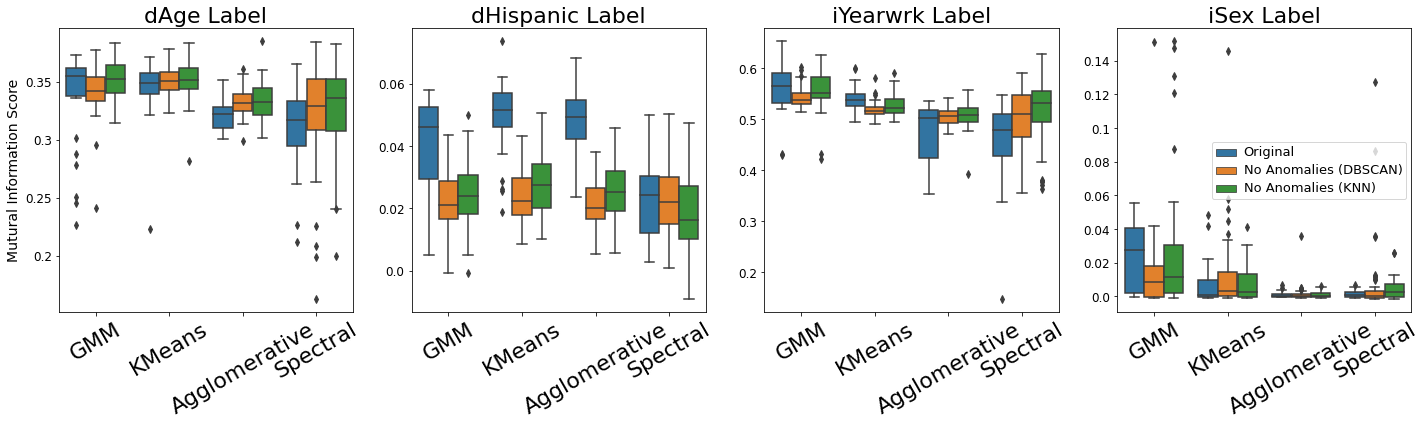

In [72]:
# visualizing the difference - MI Score

fig, ax = plt.subplots(1,4, figsize=(20,6))


for i, label in enumerate(labels_dict_compare.keys()):
    g = sns.boxplot(data=pd.concat([labels_dict_compare[label][0], 
                                    labels_dict_compare[label][1], 
                                   labels_dict_compare[label][2]],
                                   axis=0), x='model', y='value', hue='data',
                    ax=ax[i])
    g.set_xticklabels(['GMM','KMeans','Agglomerative','Spectral'], rotation=30, fontdict={'fontsize':12})
    g.set_xlabel('')
    g.set_title(f'{label} Label', fontsize=22)
    legend = g.legend()
    legend.set_title('')
    plt.setp(g.get_legend().get_texts(), fontsize=13)
    g.set_yticklabels(np.round(g.get_yticks(), 2), fontsize=12)
    if i<=2:
        if i==0:
            g.set_ylabel('Mutural Information Score', fontsize=14)
        else:
            g.set_ylabel('')
        legend.remove()
    else:
        g.set_ylabel('')
    

fig.tight_layout()
# fig.savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} Performance Without Anomalies.svg', format='svg')
plt.show()

The results are inconclusive. For iHispanic label for example it's better to have anomalies

# (5)
**Reduce the dimension of the data and propose a visualization that best characterize the clusters associated with the external variables. Please find a smart presentation scheme to highlight both clusters and variables.**

### Reduce Dimensions & visualization

We'll try several methods to reduce the dimension of the data to 2d for visualization purposes.

In [73]:
def lle(dims, data):
    embed_lle = LocallyLinearEmbedding(n_components=dims,reg=0.001)
    return embed_lle.fit_transform(data)

def pca(dims, data):
    pca = PCA(n_components=dims)
    return pca.fit_transform(data)

def kernel_pca(dims, data):
    kernel_pca = KernelPCA(n_components=dims, kernel='rbf')
    return kernel_pca.fit_transform(data)

def mds(dims, data):
    embedding = MDS(n_components=dims, metric=False)
    return embedding.fit_transform(data)

def laplacian_eigenmaps(dims, data):
    embedding = SpectralEmbedding(n_components=dims)
    return embedding.fit_transform(data)

def isomap(dims, data):
    embedding = Isomap(n_neighbors=5 , n_components=dims, eigen_solver='arpack')
    return embedding.fit_transform(data)

def tnse(dims, data):
    embedding = TSNE(n_components=dims, n_jobs=-1)
    return embedding.fit_transform(data)



In [74]:
gc.collect()

685

## Visualizing the Clusters with Dimension Reduction

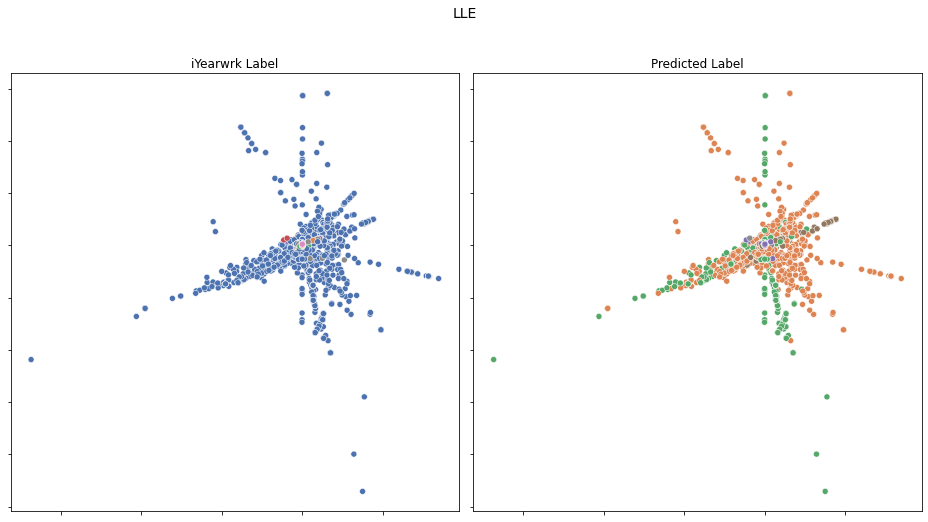

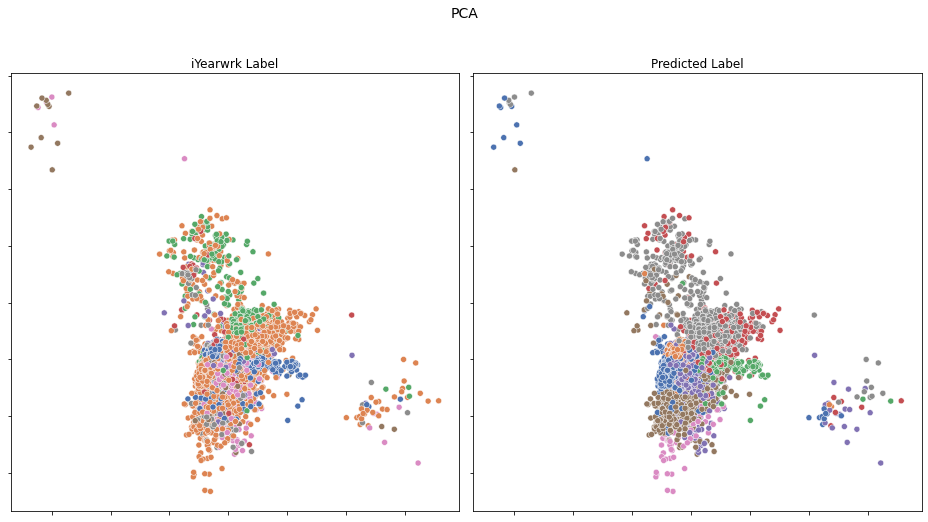

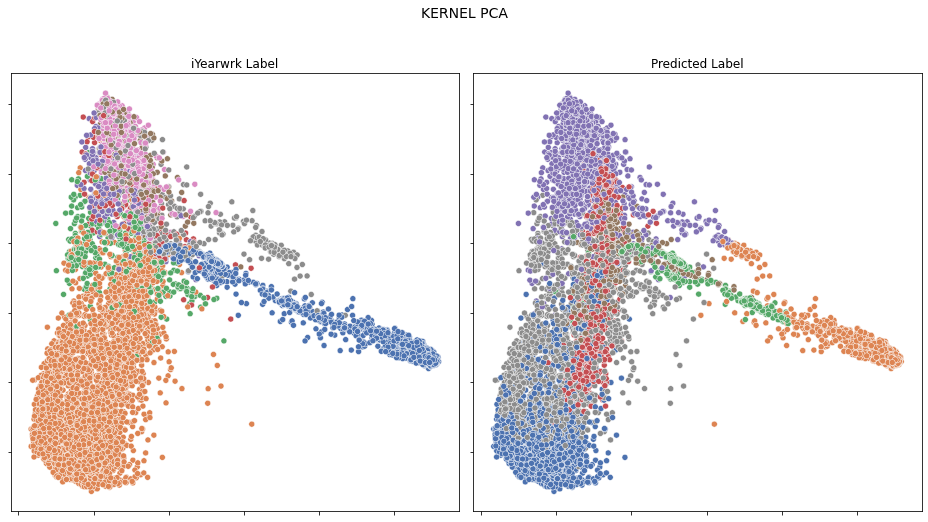

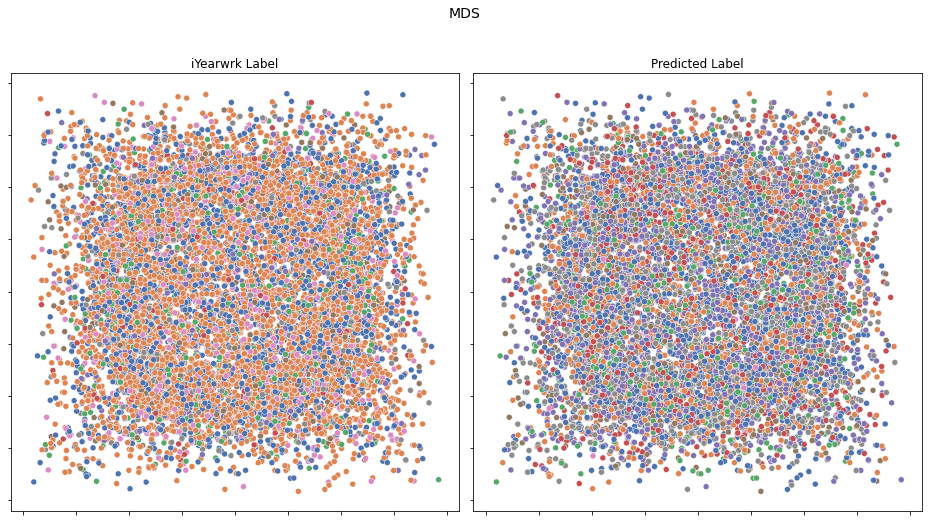

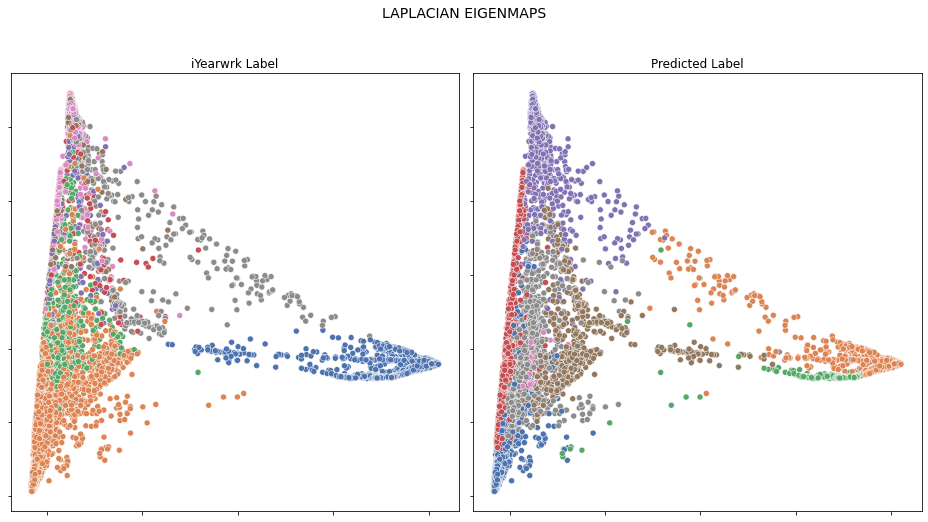

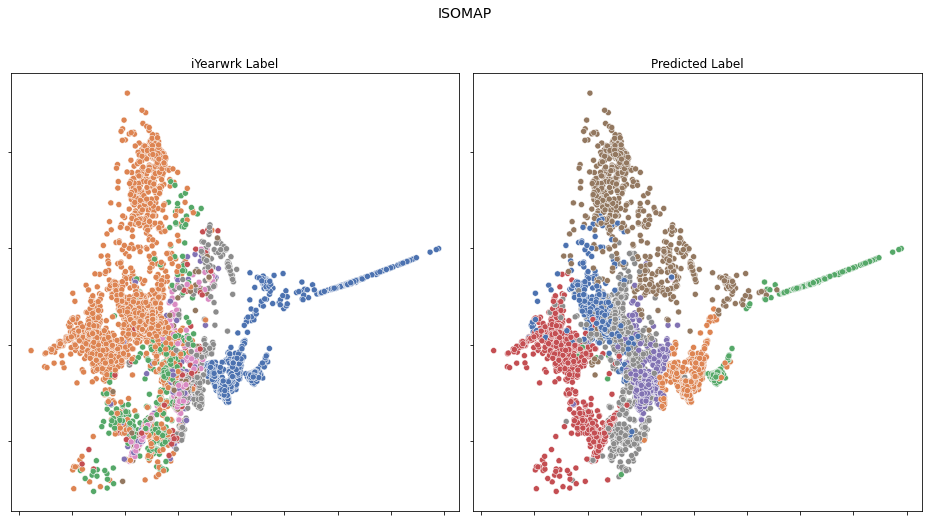

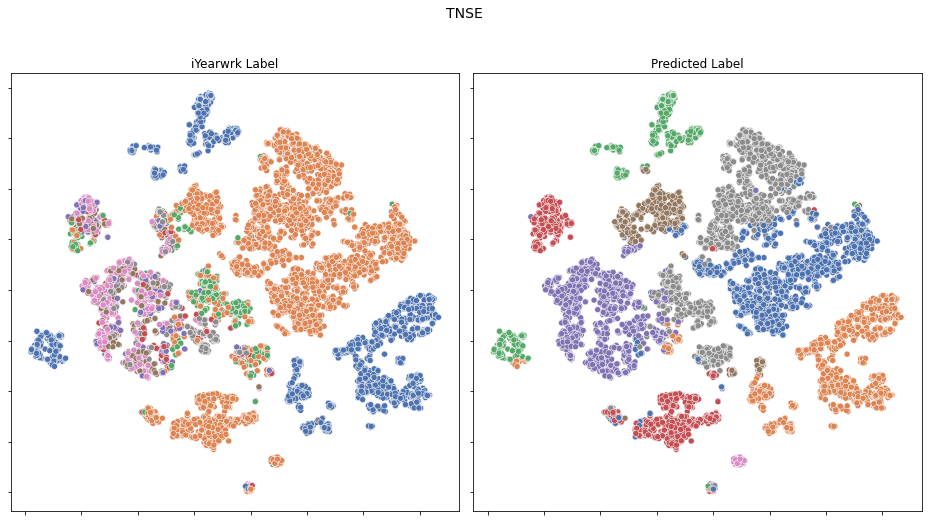

In [75]:
# we'll also assume the true labels are `iYearwrk` as this variable was the most assosiated with data

labels = external['iYearwrk'].astype(int)

# cluster
# we'll cluster using KMeans as it achieved the best performance
kmeans = tuned_models['iYearwrk'][1]
kmeans_preds = pd.Series(kmeans.predict(data), index=data.index)
kmeans_preds.name = 'preds'

reduce_algo = [lle, pca, kernel_pca, mds, laplacian_eigenmaps, isomap, tnse]

m=0
for i in range(len(reduce_algo)):
    fig, ax = plt.subplots(1,2, figsize=(13,7))
    algo_title = reduce_algo[m].__name__.replace('_', ' ').upper()

    fig.suptitle(algo_title, fontsize=14, y=1.03)

    # apply method
    reduce_x = pd.DataFrame(reduce_algo[m](2, data), index=data.index,
                          columns=['Component 1', 'Component 2'])

    # plot
    g = sns.scatterplot(data=reduce_x, x='Component 1', y='Component 2',
                  hue=labels, ax=ax[0], palette="deep", legend=False)
    g.set_title('iYearwrk Label')
    g.set_xticklabels([])
    g.set_yticklabels([])
    g.set_ylabel('')  
    g.set_xlabel('')
    # g.legend('')

    h = sns.scatterplot(data=reduce_x, x='Component 1', y='Component 2',
                  hue=kmeans_preds, ax=ax[1], palette="deep", legend=False)
    h.set_title('Predicted Label')

    h.set_xticklabels([])
    h.set_yticklabels([])
    h.set_ylabel('')  
    h.set_xlabel('')
    # h.legend('')

    # handles, llabels = g.get_legend_handles_labels()
    # fig.legend(handles, llabels, loc='best', title='Cluster')


    m+=1

    fig.tight_layout()
#     fig.savefig(f'{datetime.datetime.now().time().strftime("%H:%M:%S").replace(":","_")} Dimension Reduction with {algo_title} - Clustering First.svg', format='svg')
    plt.show()


### Summary

The first challenge in this work was to deal with large categorical data. Using statistics tests we
showed that 10,000 samples (0.4% of the data) are a satisfying representation of the data. In order
to deal with the challenge of clustering big categorical dataset we tried a few methods: (1) using
MCA and reducing the data to 10, 15, 20, and 50 dimensions or clustering the data without dimension
reduction by converting the dataset to a matrix of OHE and using different metric (Gower or Jaccard).
We conclude that reducing the dimension of data to 10 dimensions and converting it to numeric using
MCA achieved a reasonable computing time and good results, showing that CA algorithms can produce
good results when reduction of dimensions is applied before clustering due to the advantages of those
algorithms to identifying patterns in data, expressing the data in such a way as to highlight their
similarities and differences and compressing the data without much loss of information. As
to anomalies - We concluded that Anomalies found by DBSCAN were uncorrelated with any of the
external labels, whereas those found by KNN were correlated with all of the external data. Despite
this fact, removing the anomalies from the data was found to be inconclusive and in general, ineffective
in improving our clustering results. “iYearwork” label was found as the most linked external variable
to the clusters produced by the different algorithms, in particular with K-means and GMM which get
the highest scores. This can be interpreted as both of them use the same principles - GMM is an
expansion of K-means.


In this work, we’ve dealt with many challenges in order to achieve good clustering results. We saw
that the clustering techniques need to be chosen carefully with respect to the data that we cluster and
the hyperparameters. In unsupervised learning, we are missing data labeling. As a way to deal with
this absence, we can remove some variables in advance and later on use them to explain our data as
part of the path of finding the best clustering algorithm and grouping the data together. Statistical
tests were an important milestones of the analyses in order to verify our conclusions and continue to
the next steps with confidence. In conclusion, clustering is a major challenge. In order to achieve good
results, the clustering task needs to be divided into several steps where each step is based or connected to the previous ones. Each step needs to include different methods, where every method should be
fitted to the data analyzed, and statistically verified.